# 3.2. Friction Distribution between twisted Spiral Torus

In the previous chapter, the contact position and load between the spiral torus and the sphere were confirmed. As a result, it was found that the line connecting the center of the torus and the center of the sphere must overlap  with the plane through which the torus passes in order to determine the contact position.

In this chapter, the next step is to study  the distribution of Coulomb friction. All the following calculations will be performed under this boundary condition.

- The nut is completely fixed in space.
- The screw shaft is pushed in the positive direction of the x-axis.
- The screw shaft is rotating in the positive direction of the x-axis.
- The velocity relation of the screw shaft is $v=2\pi\omega$.
- The diameter of the ball is 6.35 mm (0.25 inch).
- The load at static was set to be about 40 N.


## 3.2.1. Comparison of Friction Models

|                      |      US     |     JP    |
|:---------------------|:------------|:----------|
|    Representative    | S2A, Timken |  NSK, NTN |
|     Totalization     | Integration $ \int $ ![Asset01](Asset01.svg)| Summation $ \sum $ ![Asset02](Asset02.svg)|
| contact condition |  ellipse       |   line (approximate)     |
|         Merit        |  <ul><li>Distribution in the direction of the short ellipse diameter can be considered</li><li>Less discontinuity in values</li><li>Good matching with Coulomb friction</li><li>Fast calculation speed (if pre-calculated)</li><li>No hyperparameters (mesh number, etc.)</li></ul>|<ul><li>Various friction models can be adapted</li><li>No pre-calculation required</li><li>Can be used for flexible shapes</li></ul>|
|         Demerit      |<ul><li>Recalculation is required for each model change</li><li>Bad match for anything but Simple Coulomb</li></ul>|<ul><li>Ignore the distribution of elliptical short diameters</li><li>Measures must be taken to prevent discontinuities in values</li><li>Slower computation time for smaller meshes</li></ul>|
| friction coefficient | Simple Coulomb <br> ![Coulomb](Coulomb.jpg)| Smooth Coulomb <br> ![Smooth_Coulomb](Smooth_Coulomb.jpg) |

This time, we will use simple Coulomb friction. The reasons are as follows.

- It is simple to handle.
- The surface roughness of the ball screw is large, making it difficult to form an oil film.
- (This is a chicken or egg situation, but...) Since the sliding speed of a ball screw is large, the friction coefficient should be constant no matter which model is used.
- Since it's only one ball, it won't take long to calculate it exactly. In the case of a full model, it needs to be simplified a bit.
- Since area integration is used, discontinuities in values are less likely to occur. (Discontinuity of values can be a problem in line integration.
- I simply wanted to try it for the sake of study.

However, it is known that the above assumptions cannot be applied to all situations. The reasons are as follows.

- If the oil film is thick enough, Coulomb friction will not occur.
- The maximum static friction force is not taken in consideration.


In [1]:
%config InlineBackend.figure_format = "svg"
import numpy as np
from matplotlib import pyplot as plt
import sys
import pathlib
import os
sys.path.append(str(pathlib.Path(os.path.abspath('')).resolve().parent.parent))

from _9_Mechanics.Spiral import Spiral
from _9_Mechanics.Tribology import Tribology

TB = Tribology()


### 3.2.2. Distribution of contact pressure by Hertz Contact

Regardless of which friction theory is used, the basis is the contact pressure distribution and the sliding friction at each coordinate.
First, to understand the basics, we examine the pressure distribution in the Cartesian coordinate system.


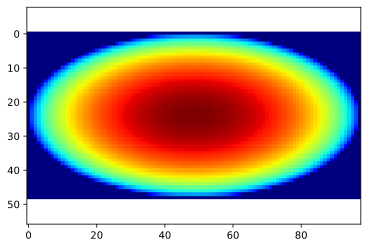

In [2]:
n = 49
x = np.linspace(-1.0, 1.0, 2 * n)
y = np.linspace(-1.0, 1.0, n)
x_, y_ = np.meshgrid(x, y)
Psq = 1.0 - np.square(x_) - np.square(y_)
Psq[Psq<0.0] = 0.0
P = np.sqrt(Psq)

plt.imshow(P, cmap=plt.cm.jet)
plt.axis('equal')
plt.show()


|Equation|Sketch|
|---|---|
|![NTN1](NTN1.jpg)|![NTN2](NTN2.jpg)|

NTN has proposed a formula for calculating the integral and slice. Here is the confirmation.

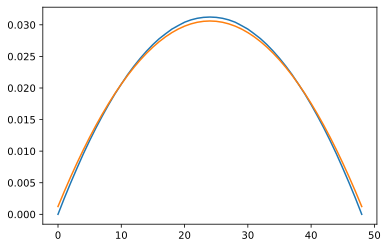

In [3]:
SFR = TB.SliceForceRatio(n)

plt.plot(P.sum(1) / P.sum())
plt.plot(SFR)
plt.show()


The Cartesian coordinate system is inefficient because the mesh exists even in places where there is no contact. Therefore, we replace it with a polar coordinate system.

$$
\begin{align}
& P(x, y) = P_{\text{max}} \sqrt{1 - \frac{x^2}{a^2} - \frac{y^2}{b^2}} \qquad
\left( -a \leq x \leq a, -b \leq y \leq b \right) \\\\
& x = ar \cos{\theta}, y = br \sin{\theta} \qquad	
\left( 0 \leq r \leq 1, 0 \leq \theta \leq 2\pi \right) \\\\
& P(r, \theta)= P_{\text{max}} \sqrt{1 - r^2}
\end{align}
$$


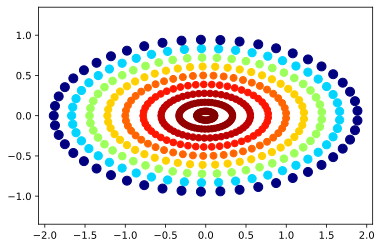

In [4]:
n = 49
r = (np.arange(int(n/5)) + 0.5) / int(n/5)
t = (np.arange(n) + 0.5) / n * 2 * np.pi

r_, t_ = np.meshgrid(r, t)
x_ = r_ * np.cos(t_) * 2.0 # = a 
y_ = r_ * np.sin(t_) * 1.0 # = b
F_ = np.sqrt(1 - np.square(r_))

plt.scatter(x_, y_, c=F_, cmap=plt.cm.jet, s=100*(1-F_*0.6))
plt.axis('equal')
plt.show()


In [5]:
def get_mesh(n_r, n_t):
    OffbyOne = lambda n : (np.arange(n) + 0.5) / n

    r = OffbyOne(n_r)
    t = OffbyOne(n_t) * 2 * np.pi

    dt = t[1] - t[0]
    r_node = np.linspace(0., 1., n_r+1)
    Antiderivative = lambda x: -(1-x*x)**1.5 / 2 / np.pi
    ratio_dt = (Antiderivative(r_node[1:]) - Antiderivative(r_node[:-1])) * dt

    r_, t_ = np.meshgrid(r, t)
    ratio, t_ = np.meshgrid(ratio_dt, t)

    r_mesh = r_.reshape(-1)
    t_mesh = t_.reshape(-1)
    ratio_mesh = ratio.reshape(-1)
    x_mesh = r_mesh * np.cos(t_mesh)
    y_mesh = r_mesh * np.sin(t_mesh)
    return r_mesh, t_mesh, ratio_mesh, x_mesh, y_mesh


In [6]:
def Make_Matrix(a, b):
    return a.reshape(-1, 1) @ b.reshape(1, -1)

def vFmTI_ball(xvw_ball, t, mode):
    
    x_ball = xvw_ball[0:3]
    v_ball = xvw_ball[3:6]
    w_ball = xvw_ball[6:9]
    
    Zeros = np.zeros(3)
    vr = np.linalg.norm(v_ball)
    x_square = np.square(x_mesh)
    y_square = np.square(y_mesh)
    
    dx      = np.zeros([2, 2])
    k_      = dx.copy()
    a_      = dx.copy()
    b_      = dx.copy()
    v_      = dx.copy()
    F_norm  = dx.copy()

    cos_sin   = np.zeros([2, 2, 2])
    SP_r_inv  = cos_sin.copy()
    R_Reduced = cos_sin.copy()
    parabola  = cos_sin.copy()
    
    exyz    = np.zeros([2, 2, 3])
    F_      = exyz.copy()
    a_dir   = exyz.copy()
    peak    = exyz.copy()
    
    eta   = np.zeros([2, 3])
    b_dir = eta.copy()
    v_eta = eta.copy()
    
    xyz2eta = np.zeros([2, 3, 3])
    
    n_mesh = len(x_mesh)
    F_mesh = np.zeros([2, 2, n_mesh])
    
    p_mesh = np.zeros([2, 2, n_mesh, 3])
    SP_v   = p_mesh.copy()
    BL_v   = p_mesh.copy()
    dv     = p_mesh.copy()
    muT    = p_mesh.copy()

    v_dir = np.zeros([2, 2, 3, n_mesh])
    muF   = v_dir.copy()
    
    for iSP, SP in enumerate(SP12):
        
        eta[iSP,:] = SP.to_eta2(x_ball)
        xyz2eta[iSP,:,:] = SP.get_xyz2eta(eta[iSP,0])
        b_dir[iSP,:] = xyz2eta[iSP,:,:].T @ np.array([1.0, 0.0, 0.0])
        v_eta[iSP,:] = xyz2eta[iSP,:,:] @ v_ball

        for i in range(2):
            cos_sin[iSP,i], dx[iSP,i], exyz[iSP,i,:] = SP.get_contact(x_ball, R, i)
            if dx[iSP,i] > 0:
                SP_r_inv[iSP,i,:] = SP.get_rho(cos_sin[iSP,i,0], i)
                R_Reduced[iSP,i,:] = 1.0 / (Ball_r_inv + SP_r_inv[iSP,i,:])
                k_[iSP,i], a_[iSP,i], b_[iSP,i] = TB.BrewHamrock(R_Reduced[iSP,i,0], R_Reduced[iSP,i,1], dx[iSP,i], E_Reduced)
                v_[iSP,i] = v_ball.dot(exyz[iSP,i,:])
                F_norm[iSP,i] = TB.Tsuji(k_[iSP,i], zeta, Ball_m, v_[iSP,i], dx[iSP,i])
                F_[iSP,i,:] = - F_norm[iSP,i] * exyz[iSP,i,:]

                a_dir[iSP,i,:] = - np.cross(b_dir[iSP,:], exyz[iSP,i,:])
                
                peak[iSP,i,:] = x_ball + (R - dx[iSP,i] / 2) * exyz[iSP,i,:]
                for j in range(2):
                    parabola[iSP,i,j] = TB.Parabola(Ball_r_inv, SP_r_inv[iSP,i,j], dx[iSP,i])
                
                p_mesh[iSP,i,:,:] = peak[iSP,i,:] + Make_Matrix(a_[iSP,i] * x_mesh, a_dir[iSP,i,:]) + Make_Matrix(b_[iSP,i] * y_mesh, b_dir[iSP,:]) + Make_Matrix(parabola[iSP,i,1] * np.square(a_[iSP,i]) * x_square - parabola[iSP,i,0] * np.square(b_[iSP,i]) * y_square, -exyz[iSP,i,:])
                F_mesh[iSP,i,:] = F_norm[iSP,i] * ratio_mesh
                
                SP_v[iSP,i,:,:]  = TB.surface_velocity(Zeros, p_mesh[iSP,i,:,:], v12[iSP], w12[iSP])
                BL_v[iSP,i,:,:]  = TB.surface_velocity(x_ball, p_mesh[iSP,i,:,:], v_ball, w_ball)
                dv[iSP,i,:,:]    = SP_v[iSP,i,:,:] - BL_v[iSP,i,:,:]
                v_dir[iSP,i,:,:] = dv[iSP,i,:,:].T * (1 / np.sqrt(np.square(dv[iSP,i,:,:]).sum(1)))
                muF[iSP,i,:,:] = F_mesh[iSP,i,:] * v_dir[iSP,i,:,:] * mu
                muT[iSP,i,:,:] = TB.calc_Torque(x_ball, p_mesh[iSP,i,:,:], muF[iSP,i,:,:].T)
                
    Fm_ball = (F_.sum(0).sum(0) + muF.sum(0).sum(0).sum(1)) / Ball_m * 1e6
    TI_ball = (muT.sum(0).sum(0).sum(0)) / Ball_I * 1e6
    
    if mode == 1:
        return a_, b_, a_dir, b_dir, dv

    if mode == 2:
        return a_, b_, a_dir, b_dir, muF, F_norm
    
    if mode == 3:
        return v_eta
    
    if mode == 4:
        return p_mesh
    
    if mode == 5:
        return muF, muT
    
    return np.concatenate([v_ball, Fm_ball, TI_ball])


In [7]:
R = 6.35 / 2
Rg = R * 1.08
ts = 45
tn = 45
dRs0 = R * 0.08 * np.cos(np.deg2rad(ts))
dRs1 = R * 0.08 * np.sin(np.deg2rad(ts))
dRn0 = R * 0.08 * np.cos(np.deg2rad(tn))
dRn1 = R * 0.08 * np.sin(np.deg2rad(tn))
PCR = 20.875
l = 10.0

SP1 = Spiral(alp=np.deg2rad(1e-1), l=l, r=PCR, eta=np.array([[-dRs0, -dRs1],[-dRs0, dRs1]]), R=np.array([Rg, Rg]))
SP2 = Spiral(alp=np.deg2rad(-1e-1), l=l, r=PCR, eta=np.array([[dRn0, -dRn1],[dRn0, dRn1]]), R=np.array([Rg, Rg]))
SP12 = [SP1, SP2]

rho = 7.9e-3 # [g/mm^3]
Ball_m = 4/3 * np.pi * R**3 * rho # [g]
Ball_I = 2/5 * Ball_m * R**2 # [g * mm^2]
Ball_r_inv = 1.0 / R
zeta = 0.2
E_Reduced = 231e3 # [N/mm^2]
rpm = 1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
mu = 0.10


Divide the face into equal parts by $r$ and $\theta$. The coordinates of each mesh are those of the center.

![Asset1](Asset1.svg)

The load on each mesh is determined by the area portion of the pressure. The Equation is as follows.
$$
\begin{align}
\text{d} F &= P \cdot \text{d} S \\\\
&= P(r, \theta) \cdot ab \cdot r \text{d} \theta \text{d} r \\\\
&= P_{\text{max}} ab \cdot r \sqrt{1 - r^2} \cdot \text{d} \theta \text{d} r \\\\
&= \frac{3F}{2 \pi} \cdot r \sqrt{1 - r^2} \cdot \text{d} \theta \text{d} r \\\\
\int_{\theta_0}^{\theta_1} \int_{r_0}^{r_1} \text{d} F &= \frac{3F}{2 \pi}(\theta_1 - \theta_0) \int_{r_0}^{r_1} r \sqrt{1 - r^2} \text{d} r \\\\
&= \frac{3F}{2 \pi}(\theta_1 - \theta_0) \left[ -\frac{1}{3} (1 - x^2)^{1.5} \right]_{r_0}^{r_1} \\\\
\end{align}
$$


In [8]:
xvw_ball = np.array([ 7.49214529e-01,  1.86156547e+01,  9.44934733e+00,  7.47973408e+01, -4.44066650e+02,  8.74837953e+02, -3.34519496e+02, -1.05000027e+02, -2.09607491e+01])

n_r = 1000
n_t = 1000

r_mesh, t_mesh, ratio_mesh, x_mesh, y_mesh = get_mesh(n_r, n_t)
muF, muT = vFmTI_ball(xvw_ball, 0, 5)

muF_true = muF[0,0].sum(1)
muT_true = muT[0,0].sum(0)

muF_true_norm = np.linalg.norm(muF[0,0].sum(1))
muT_true_norm = np.linalg.norm(muT[0,0].sum(0))


In [9]:
import warnings
warnings.filterwarnings('ignore')

def plot_t_r_mesh(n):
    global r_mesh, t_mesh, ratio_mesh, x_mesh, y_mesh

    def r2t(r):
        return (2**n / r * 2).astype(int)
    
    muF_array = np.zeros(n)
    muT_array = np.zeros(n)
    n_r_array = np.power(2, np.arange(n)+1).astype(int)
    n_t_array = (2**n / n_r_array * 2).astype(int)

    for i in range(n):

        n_r = n_r_array[i]
        n_t = n_t_array[i]

        r_mesh, t_mesh, ratio_mesh, x_mesh, y_mesh = get_mesh(n_r, n_t)
        muF, muT = vFmTI_ball(xvw_ball, 0, 5)

        muF_array[i] = np.linalg.norm(muF_true - muF[0,0].sum(1))
        muT_array[i] = np.linalg.norm(muT_true - muT[0,0].sum(0))
        
    fig, ax = plt.subplots(1)
    ax.loglog(n_t_array, muF_array/muF_true_norm, n_t_array, muT_array/muT_true_norm)
    ax.set_xticks(n_t_array)
    ax.set_xticklabels(n_t_array.astype(str))
    ax.set_xlabel('t mesh num [-]')

    secax = ax.secondary_xaxis('top', functions=(r2t, r2t))
    secax.set_xticks(n_r_array)
    secax.set_xticklabels(n_r_array.astype(str))
    secax.set_xlabel('r mesh num [-]')

    return fig, ax
    

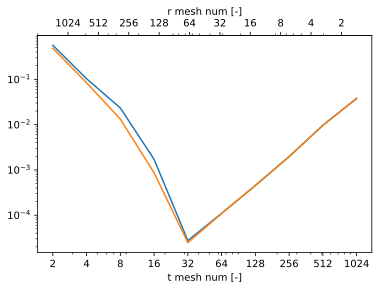

In [10]:
fig, ax = plot_t_r_mesh(10)
fig.show()


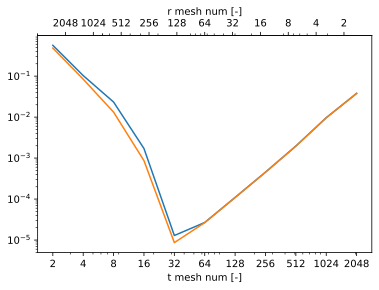

In [11]:
fig, ax = plot_t_r_mesh(11)
fig.show()


[3042 3072 3051]


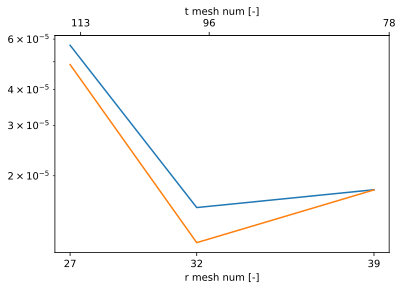

In [12]:
n = 3
hoge = 16

def r2t(r):
    return (hoge**2*12 / r).astype(int)

muF_array = np.zeros(n)
muT_array = np.zeros(n)
n_t_array = (np.sqrt(np.array([6,4,3]))*hoge).astype(int)
n_r_array = r2t(n_t_array)

print(n_r_array * n_t_array)

for i in range(n):

    n_r = n_r_array[i]
    n_t = n_t_array[i]

    r_mesh, t_mesh, ratio_mesh, x_mesh, y_mesh = get_mesh(n_r, n_t)
    muF, muT = vFmTI_ball(xvw_ball, 0, 5)

    muF_array[i] = np.linalg.norm(muF_true - muF[0,0].sum(1))
    muT_array[i] = np.linalg.norm(muT_true - muT[0,0].sum(0))
    
fig, ax = plt.subplots(1)
ax.semilogy(n_t_array, muF_array/muF_true_norm, n_t_array, muT_array/muT_true_norm)
ax.set_xticks(n_t_array)
ax.set_xticklabels(n_t_array.astype(str))
ax.set_xlabel('r mesh num [-]')

secax = ax.secondary_xaxis('top', functions=(r2t, r2t))
secax.set_xticks(n_r_array)
secax.set_xticklabels(n_r_array.astype(str))
secax.set_xlabel('t mesh num [-]')

fig.show()


In [13]:
def plot_t_3t_mesh(n_t_array):
    global r_mesh, t_mesh, ratio_mesh, x_mesh, y_mesh
    
    n = len(n_t_array)

    muF_array = np.zeros(n)
    muT_array = np.zeros(n)
    n_r_array = n_t_array * 3

    for i in range(n):

        n_r = n_r_array[i]
        n_t = n_t_array[i]

        r_mesh, t_mesh, ratio_mesh, x_mesh, y_mesh = get_mesh(n_r, n_t)
        muF, muT = vFmTI_ball(xvw_ball, 0, 5)

        muF_array[i] = np.linalg.norm(muF_true - muF[0,0].sum(1))
        muT_array[i] = np.linalg.norm(muT_true - muT[0,0].sum(0))

    def r2t_(r):
        return r * 3

    def t2r_(t):
        return t / 3

    fig, ax = plt.subplots(1)
    ax.semilogy(n_t_array, muF_array/muF_true_norm, n_t_array, muT_array/muT_true_norm)
    ax.set_xticks(n_t_array)
    ax.set_xticklabels(n_t_array.astype(str))
    ax.set_xlabel('t mesh num [-]')

    secax = ax.secondary_xaxis('top', functions=(r2t_, t2r_))
    secax.set_xticks(n_r_array)
    secax.set_xticklabels(n_r_array.astype(str))
    secax.set_xlabel('r mesh num [-]')
    
    return fig, ax


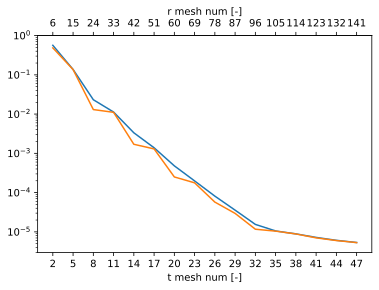

In [14]:
n_t_array = np.linspace(2, 47, 16).astype(int)
fig, ax = plot_t_3t_mesh(n_t_array)


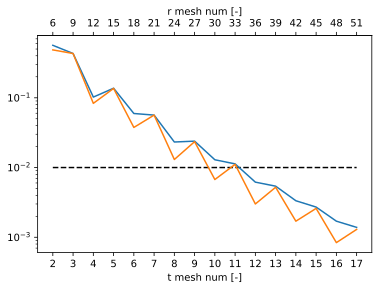

In [15]:
n_t_array = np.arange(2, 18).astype(int)
fig, ax = plot_t_3t_mesh(n_t_array)
ax.hlines([1e-2], n_t_array[0], n_t_array[-1], color='k', ls='--')


## 3.2.3. Using dynamic analysis to find the position where friction is balanced

First, set the parameters.


In [16]:
n_r = 12
n_t = 36
r_mesh, t_mesh, ratio_mesh, x_mesh, y_mesh = get_mesh(n_r, n_t)

ratio_mesh.sum()


0.9999999999999998

An explicit method is used to observe the dynamic behavior of the balls until they reach a steady state. The loads used are simply the Hertz contact and friction. The equations are shown below.

$$
\begin{align}
&\frac{\text{d}}{\text{d}t}\begin{pmatrix} x \\ v \\ \omega \end{pmatrix} 
= \begin{pmatrix} v \\ F/m \\ T/I \end{pmatrix} \\\\
\Delta u &= u_{\text{groove}} - u_{\text{ball}} \qquad
\left( u_\ast = v_\ast + \omega_\ast \times \left(p - x_\ast \right) \right) \\\\
F &= \sum_{\text{spiral}}^{\text{nut, shaft}} \sum_{\text{groove}}^{\text{left, right}} \left[ Hertzian  + \int_{\theta} \int_{r} \frac{\Delta u}{|\Delta u|} \mu \text{d}F \right] \\\\
T &= \sum_{\text{spiral}}^{\text{nut, shaft}} \sum_{\text{groove}}^{\text{left, right}} \left[ \int_{\theta} \int_{r} \frac{\Delta u}{|\Delta u|} \times R \cdot \mu \text{d}F \right]
\end{align}
$$


In order to converge as soon as possible, we searched for a location close to the steady state by manual input.
The values are as follows.

In [17]:
x_ball = np.array([0.0, PCR, 0.0])
v_ball = -1e-2 * rpm * np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R * np.sign(rpm)
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])


It is known that the contact point of a ball screw with a contact angle of 45 degrees differs depending on the direction of rotation. This phenomenon is said to be caused by Coulomb friction.

![Asset2](Asset2.svg)

First, let's look at the x-axis positive rotation (transition from the center figure to the right figure).


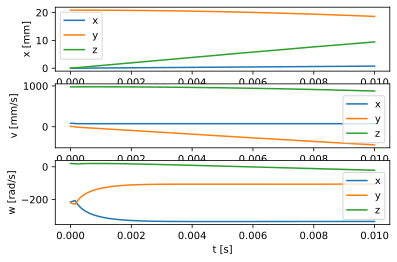

In [18]:
from scipy.integrate import odeint
t = np.linspace(0, 0.01, 1000)
sol = odeint(vFmTI_ball, xvw_ball, t, args=(0,))

fig, ax = plt.subplots(3)
ax[0].plot(t[:], sol[:, 0:3])
ax[0].set_ylabel('x [mm]')
ax[0].legend(['x', 'y', 'z'])

ax[1].plot(t[:], sol[:, 3:6])
ax[1].set_ylabel('v [mm/s]')
ax[1].legend(['x', 'y', 'z'])

ax[2].plot(t[:], sol[:, 6:9])
ax[2].set_ylabel('w [rad/s]')
ax[2].legend(['x', 'y', 'z'])
ax[2].set_xlabel('t [s]')

plt.show()


If the x-components of v and w are constant, it is a steady state.

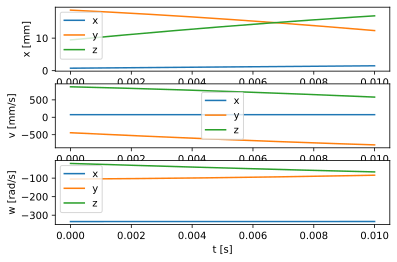

In [19]:
xvw_ball = sol[-1, :]

sol_check = odeint(vFmTI_ball, xvw_ball, t, args=(0,))
fig, ax = plt.subplots(3)
ax[0].plot(t[:], sol_check[:, 0:3])
ax[0].set_ylabel('x [mm]')
ax[0].legend(['x', 'y', 'z'])

ax[1].plot(t[:], sol_check[:, 3:6])
ax[1].set_ylabel('v [mm/s]')
ax[1].legend(['x', 'y', 'z'])

ax[2].plot(t[:], sol_check[:, 6:9])
ax[2].set_ylabel('w [rad/s]')
ax[2].legend(['x', 'y', 'z'])
ax[2].set_xlabel('t [s]')

plt.show()

We were able to confirm that it was in a steady state.

## 3.2.4. The change in sliding speed

In order to observe the change in friction, we divided the observation into "Start Condition," "Right before the Collision," "Right after the Collision," and "Steady State," respectively.


In [20]:
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings('ignore')

def plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, dv_unit):
    # Defining subplots
    fig, ax = plt.subplots(2, 2, figsize=(12, 4), dpi=300)

    # Creating plot
    a_max = a_.max()
    b_max = b_.max()

    for iSP in range(2):
        for i in range(2):
            a_mesh00 = a_[iSP,i] * x_mesh
            b_mesh00 = b_[iSP,i] * y_mesh

            dvx00 = dv[iSP,i,:,:].dot(a_dir[iSP,i,:])
            dvy00 = dv[iSP,i,:,:].dot(b_dir[iSP,:])

            dv_norm = np.sqrt(np.square(dvx00) + np.square(dvy00))

            ellipse = Ellipse(xy=(0.0, 0.0), width=2*a_[iSP,i], height=2*b_[iSP,i], edgecolor='k', fc='None')
            quiver = ax[iSP, i].quiver(a_mesh00, b_mesh00, dvx00, dvy00, dv_norm, cmap='jet')
            ax[iSP, i].add_patch(ellipse)
            ax[iSP, i].set_aspect('equal')
            ax[iSP, i].axis([-a_max, a_max, -b_max, b_max])
            ax[iSP, i].spines['right'].set_visible(False)
            ax[iSP, i].spines['top'].set_visible(False)
            ax[iSP, i].spines['left'].set_visible(False)
            ax[iSP, i].spines['bottom'].set_visible(False)
            ax[iSP, i].yaxis.set_ticks([])
            ax[iSP, i].set_xlabel('x [mm]')
            colorbar = fig.colorbar(quiver, ax=ax[iSP, i])
            colorbar.ax.set_title(dv_unit)
            
    return fig, ax


### 3.2.4.1. Start Condition (manual input)


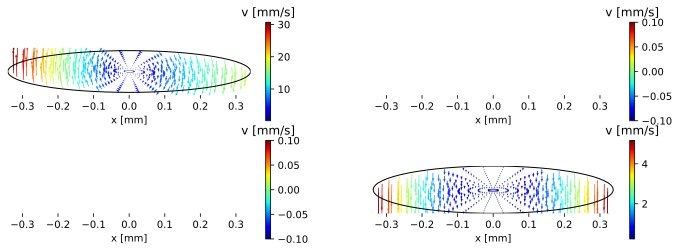

In [21]:
a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[0, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


### 3.2.4.2. Right before the Collision


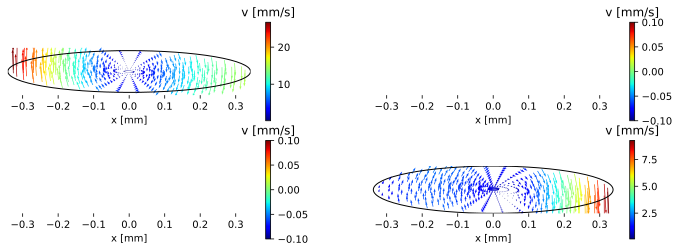

In [22]:
a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[15, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


### 3.2.4.3. Right after the Collision


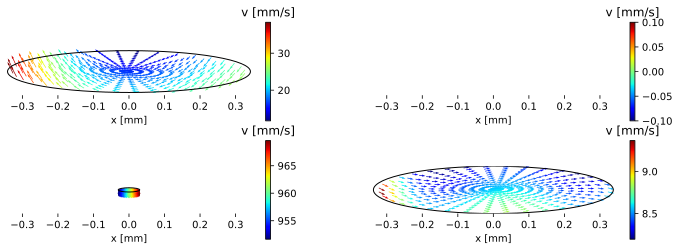

In [23]:
a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[20, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


### 3.2.4.4 Steady State


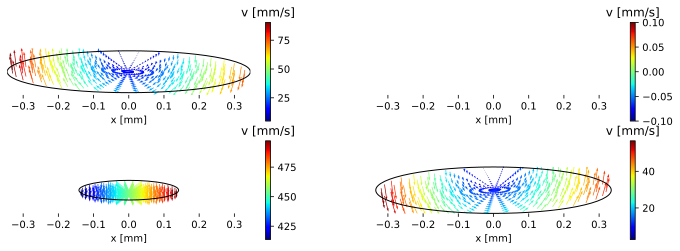

In [44]:
a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[-1, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


In [25]:
print(sol[-1, :])
print(vFmTI_ball(sol[-1, :], 0, 0))


[ 7.49210016e-01  1.86156815e+01  9.44929460e+00  7.47967885e+01
 -4.44060876e+02  8.74832706e+02 -3.34346167e+02 -1.05114502e+02
 -2.10343819e+01]
[ 7.47967885e+01 -4.44060876e+02  8.74832706e+02 -3.22543376e-01
 -4.11165677e+04 -2.08616809e+04  8.00162641e+01  9.20168223e+02
 -4.98204570e+03]


In [26]:
import pandas as pd

def plot_muF_sum(a_, b_, x_mesh, y_mesh, a_dir, b_dir, muF, F_norm):
    muF_table = pd.DataFrame(columns=['S/N', 'L/R', 'muFx [N]', 'muFy [N]', 'Fz [N]'])

    # Defining subplots
    fig, ax = plt.subplots(2, 2, figsize=(12, 4), dpi=300)

    # Creating plot
    a_max = a_.max()
    b_max = b_.max()

    for iSP in range(2):
        for i in range(2):
            a_mesh00 = a_[iSP,i] * x_mesh
            b_mesh00 = b_[iSP,i] * y_mesh

            muFx_sum = np.array([muF[iSP,i,:,:].T.dot(a_dir[iSP,i,:]).sum(), 0.0])
            muFy_sum = np.array([0.0, muF[iSP,i,:,:].T.dot(b_dir[iSP,:]).sum()])
            muF_table = muF_table.append({'S/N':str(iSP), 'L/R':str(i), 'muFx [N]':(muFx_sum + muFy_sum)[0], 'muFy [N]':(muFx_sum + muFy_sum)[1], 'Fz [N]':F_norm[iSP,i]}, ignore_index=True)

            ellipse = Ellipse(xy=(0.0, 0.0), width=2*a_[iSP,i], height=2*b_[iSP,i], edgecolor='k', fc='None')
            quiver = ax[iSP, i].quiver([0.0, 0.0], [0.0, 0.0], muFx_sum, muFy_sum, scale=5)

            ax[iSP, i].add_patch(ellipse)
            ax[iSP, i].set_aspect('equal')
            ax[iSP, i].axis([-a_max, a_max, -b_max, b_max])
            ax[iSP, i].spines['right'].set_visible(False)
            ax[iSP, i].spines['top'].set_visible(False)
            ax[iSP, i].spines['left'].set_visible(False)
            ax[iSP, i].spines['bottom'].set_visible(False)
            ax[iSP, i].yaxis.set_ticks([])
            ax[iSP, i].set_xlabel('x [mm]')
            
    return fig, ax, muF_table


Since the distribution of the sliding velocity has been confirmed, the friction force is illustrated by its integral (actually, sum). The x- and y-components are represented by independent arrows.

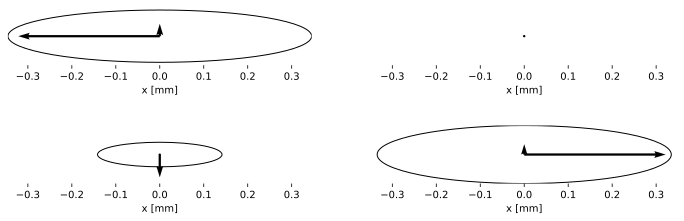

  S/N L/R  muFx [N]  muFy [N]     Fz [N]
0   0   0 -2.329602  0.204460  52.095456
1   0   1  0.000000  0.000000   0.000000
2   1   0  0.008724 -0.375962   3.760813
3   1   1  2.328384  0.170752  51.686860


In [45]:
a_, b_, a_dir, b_dir, muF, F_norm = vFmTI_ball(sol[-1, :], 0, 2)
fig, ax, muF_table = plot_muF_sum(a_, b_, x_mesh, y_mesh, a_dir, b_dir, muF, F_norm)
plt.show()
print(muF_table)


The center of the vortex was observed at the two points that support the main load. The presence of the vortex center indicates pure rolling. At the third point, which is the secondary load, the sliding friction was completely opposite to the direction of motion. This indicates that the object is rubbing in the opposite direction, like a frame. However, since the friction is weak, it does not result in pure rolling, but rather in slippage.

![Asset3](Asset3.svg)

In [28]:
v_eta = vFmTI_ball(sol[-1, :], 0, 3)
print(v_eta)


[[ 9.83929308e+02 -1.84496974e-02 -2.76520007e-03]
 [ 9.83929309e+02  1.34047762e-03 -2.76521319e-03]]


### 3.2.4.5. Steady State of Reverse Rotation


In [29]:
rpm = -1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
x_ball = np.array([0.0, PCR, 0.0])
v_ball = -1e-2 * rpm * np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R * np.sign(rpm)
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])
t = np.linspace(0, 0.01, 1000)
sol = odeint(vFmTI_ball, xvw_ball, t, args=(0,))


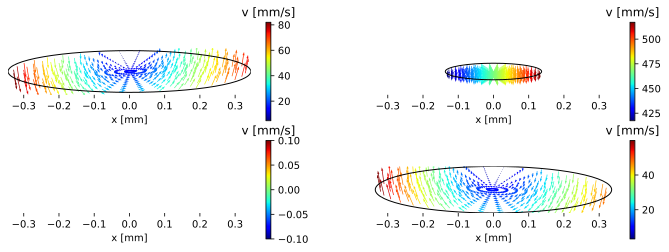

In [30]:
a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[-1, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


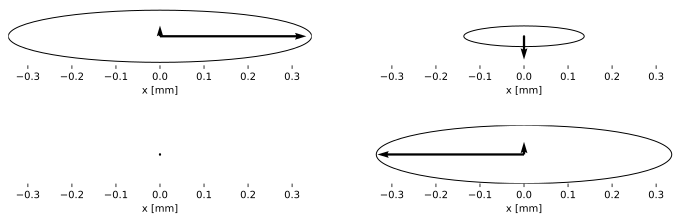

  S/N L/R  muFx [N]  muFy [N]     Fz [N]
0   0   0  2.412411  0.176074  52.760177
1   0   1  0.012111 -0.385418   3.856288
2   1   0  0.000000  0.000000   0.000000
3   1   1 -2.416899  0.208574  53.249970


In [31]:
a_, b_, a_dir, b_dir, muF, F_norm = vFmTI_ball(sol[-1, :], 0, 2)
fig, ax, muF_table = plot_muF_sum(a_, b_, x_mesh, y_mesh, a_dir, b_dir, muF, F_norm)
plt.show()
print(muF_table)


In [32]:
v_eta = vFmTI_ball(sol[-1, :], 0, 3)
print(v_eta)


[[-9.76077077e+02  6.90530122e-03 -8.15341428e-03]
 [-9.76077077e+02 -1.27299558e-02 -8.15341874e-03]]


### 3.2.4.6. Results Summary

- The sub-loaded points slide parallel to the direction of motion.
- The coefficient of friction at that point, $\mu$, is approximately equal to the input, 0.10.
- The direction of velocity in the steady state is parallel to the groove where the two points contact.
- The friction coefficient of the main load, $\mu$, is about 0.05, less than the input of 0.10.
- The sum of the friction of the main load is greater than the vertical drag of the secondary load. (Because of the difference of contact angle?)


## 3.2.5. New products developed by NSK

As mentioned above, with conventional ball screws with a contact angle of 45 degrees, the contact state of the balls changes greatly depending on the direction of rotation. NSK has therefore developed a ball screw that contact the balls at three points even when the screw is stationary.

We will verify whether this newly developed ball screw is really stable by observing the friction state.

![Asset4](Asset4.svg)


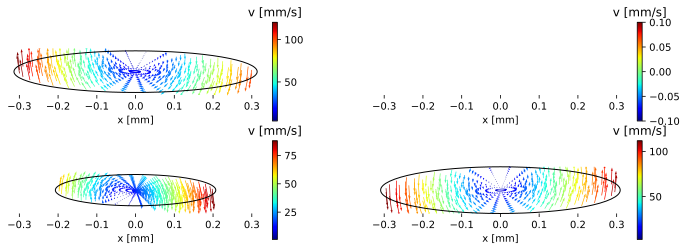

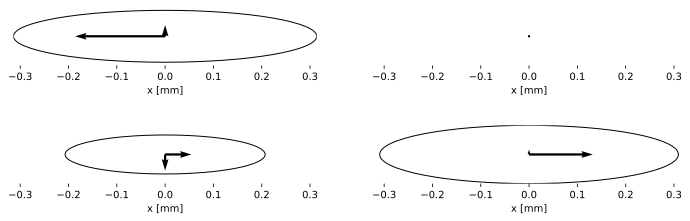

  S/N L/R  muFx [N]  muFy [N]     Fz [N]
0   0   0 -1.484352  0.183463  38.792062
1   0   1  0.000000  0.000000   0.000000
2   1   0  0.433495 -0.264362  12.149967
3   1   1  1.051319  0.080323  40.674255
[[ 8.43069214e+02 -1.80034404e-02 -1.19412774e-03]
 [ 8.43069215e+02 -1.04682017e-03 -1.19414235e-03]]


In [33]:
ts = 40
tn = 55
dRs0 = R * 0.08 * np.cos(np.deg2rad(ts))
dRs1 = R * 0.08 * np.sin(np.deg2rad(ts))
dRn0 = R * 0.08 * np.cos(np.deg2rad(tn))
dRn1 = R * 0.08 * np.sin(np.deg2rad(tn))

SP1 = Spiral(alp=np.deg2rad(1e-1), l=l, r=PCR, eta=np.array([[-dRs0, -dRs1],[-dRs0, dRs1]]), R=np.array([Rg, Rg]))
SP2 = Spiral(alp=np.deg2rad(-1e-1), l=l, r=PCR, eta=np.array([[dRn0, -dRn1],[dRn0, dRn1]]), R=np.array([Rg, Rg]))
SP12 = [SP1, SP2]

rpm = 1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
x_ball = np.array([0.0, PCR, 0.0])
v_ball = -1e-2 * rpm * np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R * np.sign(rpm)
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])
t = np.linspace(0, 0.01, 1000)
sol = odeint(vFmTI_ball, xvw_ball, t, args=(0,))

a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[-1, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')

a_, b_, a_dir, b_dir, muF, F_norm = vFmTI_ball(sol[-1, :], 0, 2)
fig, ax, muF_table = plot_muF_sum(a_, b_, x_mesh, y_mesh, a_dir, b_dir, muF, F_norm)
plt.show()
print(muF_table)

v_eta = vFmTI_ball(sol[-1, :], 0, 3)
print(v_eta)


The center of the vortex was observed at all three points. Let's try to calculate the reverse rotation.


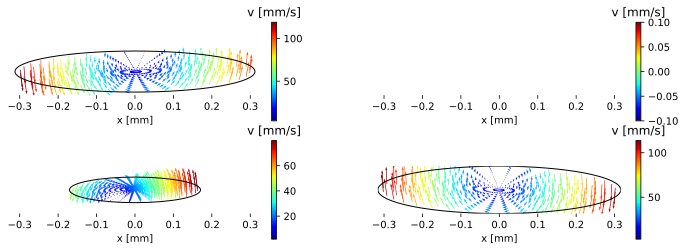

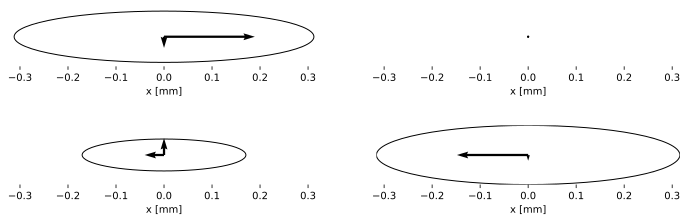

  S/N L/R  muFx [N]  muFy [N]     Fz [N]
0   0   0  1.496314 -0.184026  40.498548
1   0   1  0.000000  0.000000   0.000000
2   1   0 -0.320807  0.277729   7.487433
3   1   1 -1.175643 -0.094332  42.824921
[[-8.42672106e+02  1.17417283e-02  1.06123910e-02]
 [-8.42672106e+02 -5.20703438e-03  1.06123960e-02]]


In [34]:
rpm = -1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
x_ball = np.array([0.0, PCR, 0.0])
v_ball = -1e-2 * rpm * np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R * np.sign(rpm)
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])
t = np.linspace(0, 0.01, 1000)
sol = odeint(vFmTI_ball, xvw_ball, t, args=(0,))

a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[-1, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')

a_, b_, a_dir, b_dir, muF, F_norm = vFmTI_ball(sol[-1, :], 0, 2)
fig, ax, muF_table = plot_muF_sum(a_, b_, x_mesh, y_mesh, a_dir, b_dir, muF, F_norm)
plt.show()
print(muF_table)

v_eta = vFmTI_ball(sol[-1, :], 0, 3)
print(v_eta)


### 3.2.5.1. Results Summary

In both rotations, the three points were confirmed to be pure rolling. This indicates that the rotation of the ball is as shown in the following figure.

![Asset5](Asset5.svg)

From the similarity of the two steady states, we can infer the following: this new product will tolerate changes in rotation with stability.


## 3.2.6. Single-arch Ball Screw



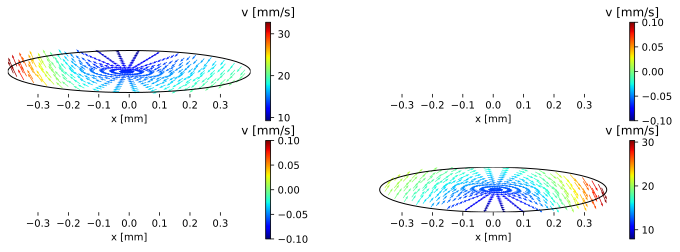

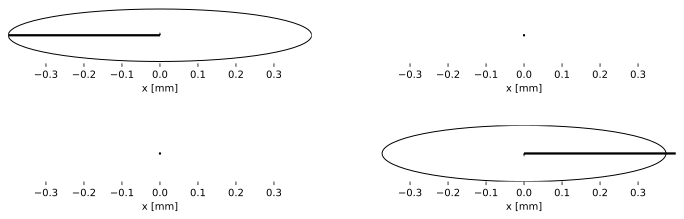

  S/N L/R  muFx [N]  muFy [N]     Fz [N]
0   0   0 -5.163334  0.053431  76.557617
1   0   1  0.000000  0.000000   0.000000
2   1   0  0.000000  0.000000   0.000000
3   1   1  5.179371 -0.054504  76.638683
[[ 9.80128283e+02 -5.31389789e-02 -4.31530640e-02]
 [ 9.80128284e+02 -3.34351932e-02 -4.31531304e-02]]


In [35]:
ts = 45
tn = 45
dRs0 = R * 0.08 * np.cos(np.deg2rad(ts))
dRs1 = R * 0.08 * np.sin(np.deg2rad(ts))
dRn0 = R * 0.08 * np.cos(np.deg2rad(tn))
dRn1 = R * 0.08 * np.sin(np.deg2rad(tn))

SP1 = Spiral(alp=np.deg2rad(1e-1), l=l, r=PCR, eta=np.array([[-dRs0, -dRs1],[-dRs0, dRs1]]), R=np.array([Rg, 2*Rg]))
SP2 = Spiral(alp=np.deg2rad(-1e-1), l=l, r=PCR, eta=np.array([[dRn0, -dRn1],[dRn0, dRn1]]), R=np.array([2*Rg, Rg]))
SP12 = [SP1, SP2]

rpm = 1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
x_ball = np.array([0.0, PCR, 0.0])
v_ball = -1e-2 * rpm * np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R * np.sign(rpm)
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])
t = np.linspace(0, 0.01, 1000)
sol = odeint(vFmTI_ball, xvw_ball, t, args=(0,))

a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[-1, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')

a_, b_, a_dir, b_dir, muF, F_norm = vFmTI_ball(sol[-1, :], 0, 2)
fig, ax, muF_table = plot_muF_sum(a_, b_, x_mesh, y_mesh, a_dir, b_dir, muF, F_norm)
plt.show()
print(muF_table)

v_eta = vFmTI_ball(sol[-1, :], 0, 3)
print(v_eta)


### 3.2.6.1. Results Summary

As expected, the contact angle continued to increase until the angle between the two vectors of the combined force of each friction and vertical drag became 180 degrees.
In addition, the load changed from 40 N to 80 N under the condition of screw and nut fixation. In other words, the stiffness has doubled. This indicates that the Single-arch has poor rotational stability.

![Asset6](Asset6.svg)

### Apendix (Start with pure roll at 3 points)

If we start with a 45-degree contact angle ball screw with all three points in a pure rolling state as the initial state, we will observe whether the screw settles down to a steady state.

In other words, we have a suspicion that there may be more than one solution to the steady state, and this is the verification of this suspicion.

![Asset7](Asset7.svg)


In [36]:
ts = 45
tn = 45
dRs0 = R * 0.08 * np.cos(np.deg2rad(ts))
dRs1 = R * 0.08 * np.sin(np.deg2rad(ts))
dRn0 = R * 0.08 * np.cos(np.deg2rad(tn))
dRn1 = R * 0.08 * np.sin(np.deg2rad(tn))

SP1 = Spiral(alp=np.deg2rad(1e-1), l=l, r=PCR, eta=np.array([[-dRs0, -dRs1],[-dRs0, dRs1]]), R=np.array([Rg, Rg]))
SP2 = Spiral(alp=np.deg2rad(-1e-1), l=l, r=PCR, eta=np.array([[dRn0, -dRn1],[dRn0, dRn1]]), R=np.array([Rg, Rg]))
SP12 = [SP1, SP2]

rpm = 1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
x_ball = np.array([0.0, PCR, 0.0])
v_ball = -1e-2 * rpm * np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R * np.sign(rpm)
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])
t = np.linspace(0, 0.01, 1000)
sol = odeint(vFmTI_ball, xvw_ball, t, args=(0,))


In [37]:
def Sliding_Vector(vw_ball, x_ball):
    
    v_ball = vw_ball[0:3]
    w_ball = vw_ball[3:6]
    
    Zeros = np.zeros(3)
    
    dv    = np.zeros([2, 2, 3])

    for iSP, SP in enumerate(SP12):
        
        eta = SP.to_eta2(x_ball)
        xyz2eta = SP.get_xyz2eta(eta[0])
        b_dir = xyz2eta.T @ np.array([1.0, 0.0, 0.0])
        v_eta = xyz2eta @ v_ball

        for i in range(2):
            cos_sin, dx, exyz = SP.get_contact(x_ball, R, i)
            if dx > 0:
                SP_r_inv = SP.get_rho(cos_sin[0], i)
                R_Reduced = 1.0 / (Ball_r_inv + SP_r_inv)
                k_, a_, b_ = TB.BrewHamrock(R_Reduced[0], R_Reduced[1], dx, E_Reduced)

                peak = x_ball + (R - dx / 2) * exyz
                
                SP_v  = TB.surface_velocity(Zeros, peak, v12[iSP], w12[iSP])
                BL_v  = TB.surface_velocity(x_ball, peak, v_ball, w_ball)
                ihoge = 3 * (iSP * 2 + i)
                dv[iSP,i,:] = SP_v - BL_v

    fuga = np.square(dv).reshape(-1)

    return np.concatenate([fuga[:3]+fuga[6:9], fuga[6:9]+fuga[9:]])


In [38]:
from scipy.optimize import fsolve

provisional0 = sol[-1, :].copy()
provisional = fsolve(Sliding_Vector, provisional0[3:], args=(provisional0[:3]))


In [39]:
provisional1 = provisional0.copy()
provisional1[3:] = provisional


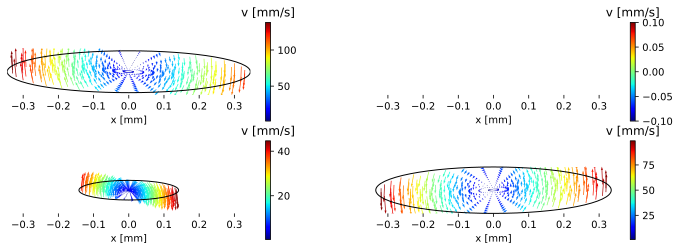

In [40]:
a_, b_, a_dir, b_dir, dv = vFmTI_ball(provisional1, 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


Since the center of the vortex is located at all three points, it can be seen that the initial state was calculated correctly. The results of the dynamic analysis are shown below.

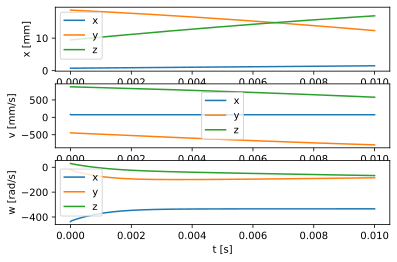

In [41]:
xvw_ball = sol[-1, :]

sol_check = odeint(vFmTI_ball, provisional1, t, args=(0,))
fig, ax = plt.subplots(3)
ax[0].plot(t[:], sol_check[:, 0:3])
ax[0].set_ylabel('x [mm]')
ax[0].legend(['x', 'y', 'z'])

ax[1].plot(t[:], sol_check[:, 3:6])
ax[1].set_ylabel('v [mm/s]')
ax[1].legend(['x', 'y', 'z'])

ax[2].plot(t[:], sol_check[:, 6:9])
ax[2].set_ylabel('w [rad/s]')
ax[2].legend(['x', 'y', 'z'])
ax[2].set_xlabel('t [s]')

plt.show()

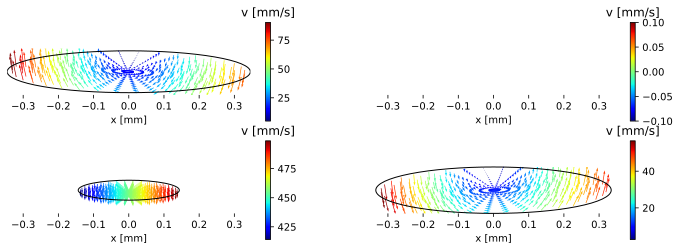

In [42]:
a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol_check[-1,:], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


### Results summary

As shown in the figure above, we started the initial state with three points of pure rolling, but the result settled down to the same result as the first calculation. Although it is too early to draw any conclusions based on this one example, the hypothesis that "the steady-state solution will converge to unique" was obtained. 
We will confirm this hypothesis through further verification in the future.
